In [1]:
import numpy as np
from scipy import fftpack
from skimage import io, color
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

In [2]:
# define Fourier Transform
def ft_2d_iter(_image, k, l):
    res = 0
    N = _image.shape[0]
    for i in range(_image.shape[0]):
        for j in range(_image.shape[1]):
            res += _image[i, j] * np.e**(-2j * np.pi * ((k * i / N) + (l * j / N)))
    return res


def ft_2d(_image):
    F = []
    N = _image.shape[0]
    for k in range(N):
        F.append([])
        for l in range(N):
            F[k].append(ft_2d_iter(_image, k, l))
    return np.array(F)


def ftshift(F):
    N, M = F.shape
    shifted = np.zeros_like(F)
    
    shifted[N//2:, M//2:] = F[:N//2, :M//2]
    shifted[:N//2, :M//2] = F[N//2:, M//2:]
    shifted[N//2:, :M//2] = F[:N//2, M//2:]
    shifted[:N//2, M//2:] = F[N//2:, :M//2]
    return shifted

In [3]:
# Scale to see something
def scale_log_ft(arr):
    R = np.max(arr)
    c = 255 / np.log10(1 + R)
    print(f'{R=}\t{c=}')
    return c * np.log10(1.0 + arr)

def scale_linear_ft(arr):
    # Simple min-max normalization to 0-255 range
    return 255 * (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [4]:
# Inverse and unscale
def ift_2d_iter(_F, k, l):
    res = 0
    N = _F.shape[0]
    for i in range(N):
        for j in range(N):
            res += _F[i, j] * np.e**(2j * np.pi * ((i * k / N) + (j * l / N)))
    return res / (N * N)  # Don't forget normalization factor 1/N^2


def ift_2d(_F):
    result = []
    N = _F.shape[0]
    for k in range(N):
        result.append([])
        for l in range(N):
            result[k].append(ift_2d_iter(_F, k, l))
    return np.array(result)


def unscale_ft(arr, R):
    """Reverse the logarithmic scaling"""
    c = 255 / np.log(1 + R)
    return np.exp(arr / c) - 1.0

def inverse_ftshift(F):
    """Reverse the fftshift operation"""
    N, M = F.shape
    unshifted = np.zeros_like(F)
    
    unshifted[:N//2, :M//2] = F[N//2:, M//2:]
    unshifted[N//2:, M//2:] = F[:N//2, :M//2]
    unshifted[:N//2, M//2:] = F[N//2:, :M//2]
    unshifted[N//2:, :M//2] = F[:N//2, M//2:]
    return unshifted

In [5]:
def apply_window(image):
    # Create 2D Hanning window
    h, w = image.shape
    window = np.outer(np.hanning(h), np.hanning(w))
    
    # Apply window
    return image * window

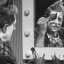

In [6]:
image_path = "../images/real.png" # will not work for non-squared image
image = Image.open(image_path).convert('L') # convert to gray-scale
image_array = np.array(image) / 255.0 # normalize image
display(Image.fromarray((image_array * 255.0).astype(np.uint8)))

In [7]:
# Apply ft and compare
my_ft = ft_2d(image_array)
np_fft = np.fft.fft2(image_array)

is_ft_close = np.allclose(my_ft, np_fft)
print(f'{is_ft_close=}')

is_ft_close=True


In [8]:
# Shift ft and compare
my_ft_shifted = ftshift(my_ft)
np_fft2_shifted = np.fft.fftshift(np_fft)

is_shift_close = np.allclose(my_ft_shifted, np_fft2_shifted)
print(f'{is_shift_close=}')

is_shift_close=True


In [9]:
# Split complex numbers in FT into 2: magnitude (v length) and angle w.r.t. the origin
magnitude_spectrum = np.abs(my_ft_shifted)
phase_spectrum = np.pi + np.angle(my_ft_shifted)

In [10]:
magnitude_spectrum_unshifted = np.abs(my_ft)
phase_spectrum_unshifted = np.pi + np.angle(my_ft)

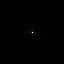

In [11]:
display(Image.fromarray(scale_linear_ft(magnitude_spectrum).astype(np.uint8)))

R=1937.0392156862545	c=77.56978285685898


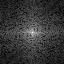

In [12]:
display(Image.fromarray(scale_log_ft(magnitude_spectrum).astype(np.uint8), mode='L'))

In [13]:
original_R = np.max(np.abs(magnitude_spectrum))
scaled_magnitude = scale_log_ft(magnitude_spectrum)

unscaled_magnitude = unscale_ft(scaled_magnitude, original_R)
is_unscaled_close = np.allclose(np.abs(np_fft2_shifted), unscaled_magnitude)

unshifted_magnitude = inverse_ftshift(unscaled_magnitude)
is_unshifted_close = np.allclose(np.abs(np_fft), unshifted_magnitude)
print(f'{is_unscaled_close=}')
print(f'{is_unshifted_close=}')

R=1937.0392156862545	c=77.56978285685898
is_unscaled_close=True
is_unshifted_close=True


In [14]:
np_ifft = np.fft.ifft2(np_fft)  # NumPy's inverse FFT for comparison

my_ift = ift_2d(my_ft)

# Check if our implementation matches NumPy's
print("Inverse FFT matches NumPy:", np.allclose(my_ift, np_ifft))

Inverse FFT matches NumPy: True


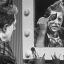

In [15]:
Image.fromarray(np.abs(my_ift * 255).astype(np.uint8))

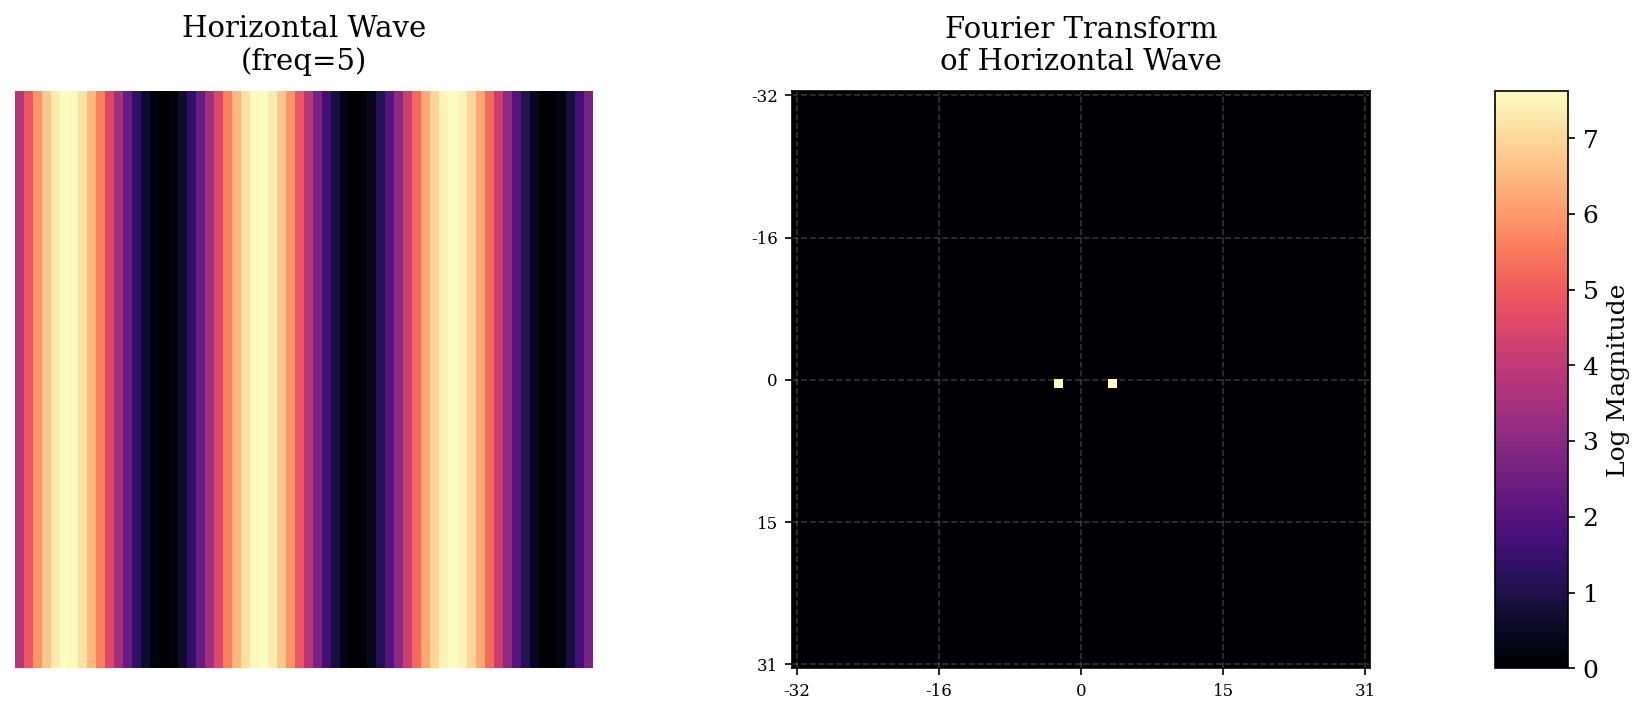

Image shape: (64, 64)
FFT shape: (64, 64)


In [16]:
def create_frequency_visualization(size=64, freq=5, figsize=(14, 5), dpi=150):
    """
    Create a publication-ready figure showing a frequency wave and its FFT
    using magma colormap for consistency with the reference style
    """
    # Set font properties
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12
    
    # Create wave data
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)
    horizontal_wave = np.sin(2 * np.pi * freq * X / size)
    
    # Create figure with GridSpec for better colorbar placement
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 0.1])
    
    # Plot horizontal wave
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(horizontal_wave, cmap='magma')
    ax1.set_title('Horizontal Wave\n(freq=5)', pad=10, fontsize=14)
    ax1.axis('off')
    
    # Compute and plot FFT
    fft_horizontal = np.fft.fft2(horizontal_wave)
    fft_shifted = np.fft.fftshift(fft_horizontal)
    
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(np.log(np.abs(fft_shifted) + 1), cmap='magma')
    ax2.set_title('Fourier Transform\nof Horizontal Wave', pad=10, fontsize=14)
    
    # Set ticks for FFT plot
    ax2.set_xticks(np.linspace(0, size-1, 5))
    ax2.set_yticks(np.linspace(0, size-1, 5))
    
    # Convert tick positions to centered coordinates
    x_positions = ax2.get_xticks()
    y_positions = ax2.get_yticks()
    x_labels = [int(x - size//2) for x in x_positions]
    y_labels = [int(y - size//2) for y in y_positions]
    
    # Set the tick labels
    ax2.set_xticklabels(x_labels)
    ax2.set_yticklabels(y_labels)
    
    # Style the ticks
    ax2.tick_params(axis='both', which='major', labelsize=8, colors='black')
    ax2.grid(True, color='white', alpha=0.2, linestyle='--')
    
    # Add colorbar in the third column
    cax = fig.add_subplot(gs[0, 2])
    plt.colorbar(im2, cax=cax, label='Log Magnitude')
    
    # Adjust layout with smaller spacing
    plt.subplots_adjust(wspace=0.1)
    
    return fig

# Create and save figure
fig = create_frequency_visualization(freq=3)
plt.savefig('../results/frequency_visualization.png', bbox_inches='tight', dpi=300)
plt.show()

# Print array shapes for reference
size = 64
wave = np.zeros((size, size))
print("Image shape:", wave.shape)
print("FFT shape:", np.fft.fft2(wave).shape)

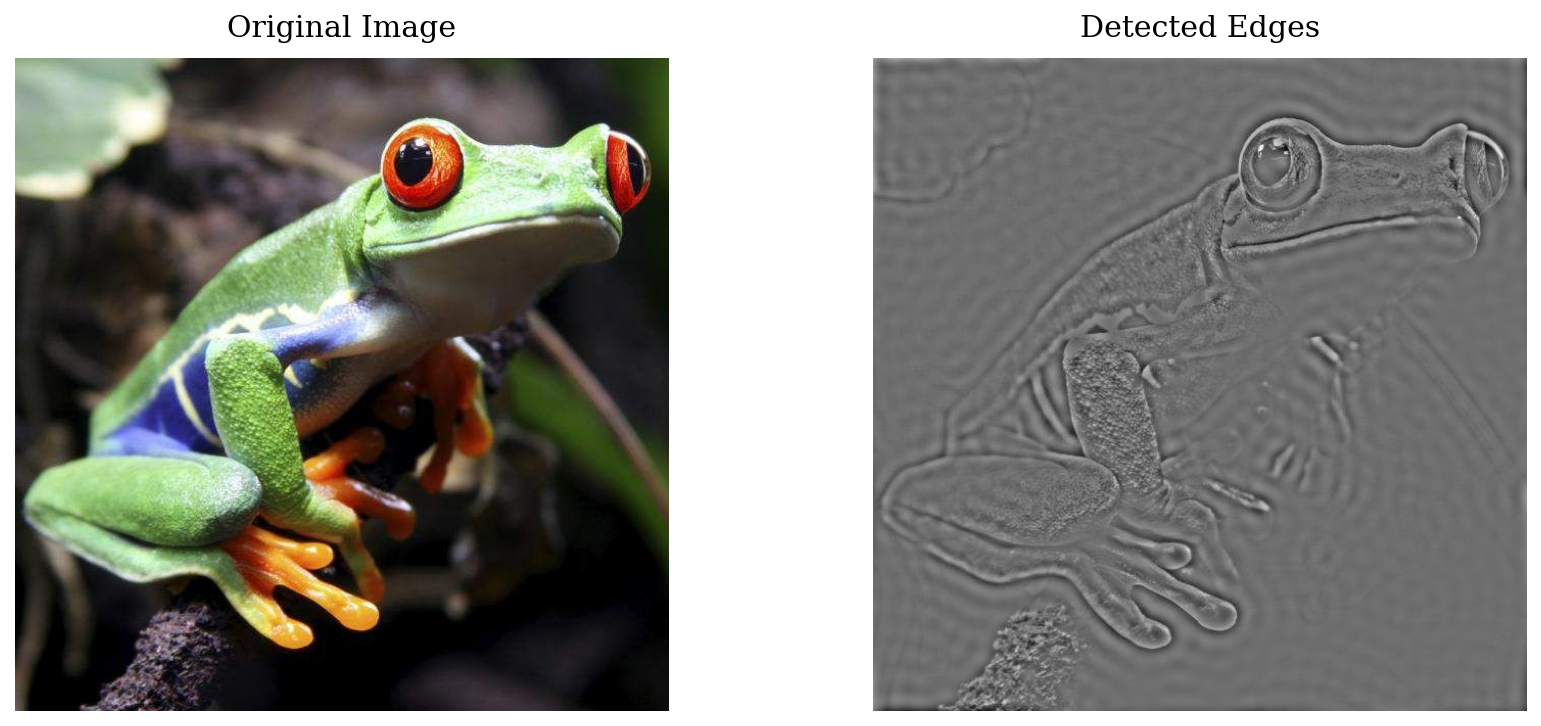

In [17]:
def detect_edges_fourier(image):
    """
    Detect edges using Fourier Transform
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray_img = color.rgb2gray(image)
    else:
        gray_img = image.copy()
    
    # Compute FFT
    fft_orig = fftpack.fft2(gray_img)
    fft_shifted = fftpack.fftshift(fft_orig)
    
    # Create high-pass filter
    rows, cols = gray_img.shape
    crow, ccol = rows//2, cols//2
    radius = 30
    
    # Create a high pass filter mask
    y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    mask = x*x + y*y > radius*radius
    
    # Apply filter and inverse FFT
    fft_filtered = fft_shifted * mask
    img_back = np.real(fftpack.ifft2(fftpack.ifftshift(fft_filtered)))
    
    return img_back

def create_edge_detection_figure(image, title="Edge Detection using Fourier Transform", 
                               figsize=(12, 5), dpi=150):
    """
    Create a publication-ready figure showing original image and detected edges
    """
    # Set font properties
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    # fig.suptitle(title, fontsize=14, y=0.95)
    
    # Plot original image
    ax1.imshow(image)
    ax1.set_title('Original Image', pad=10)
    ax1.axis('off')
    
    # Detect and plot edges
    edges = detect_edges_fourier(image)
    ax2.imshow(edges, cmap='gray')
    ax2.set_title('Detected Edges', pad=10)
    ax2.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    return fig

image = io.imread('../images/frog.jpg')

# Create and save figure
fig = create_edge_detection_figure(image)
plt.savefig('../results/edge_detection_result.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

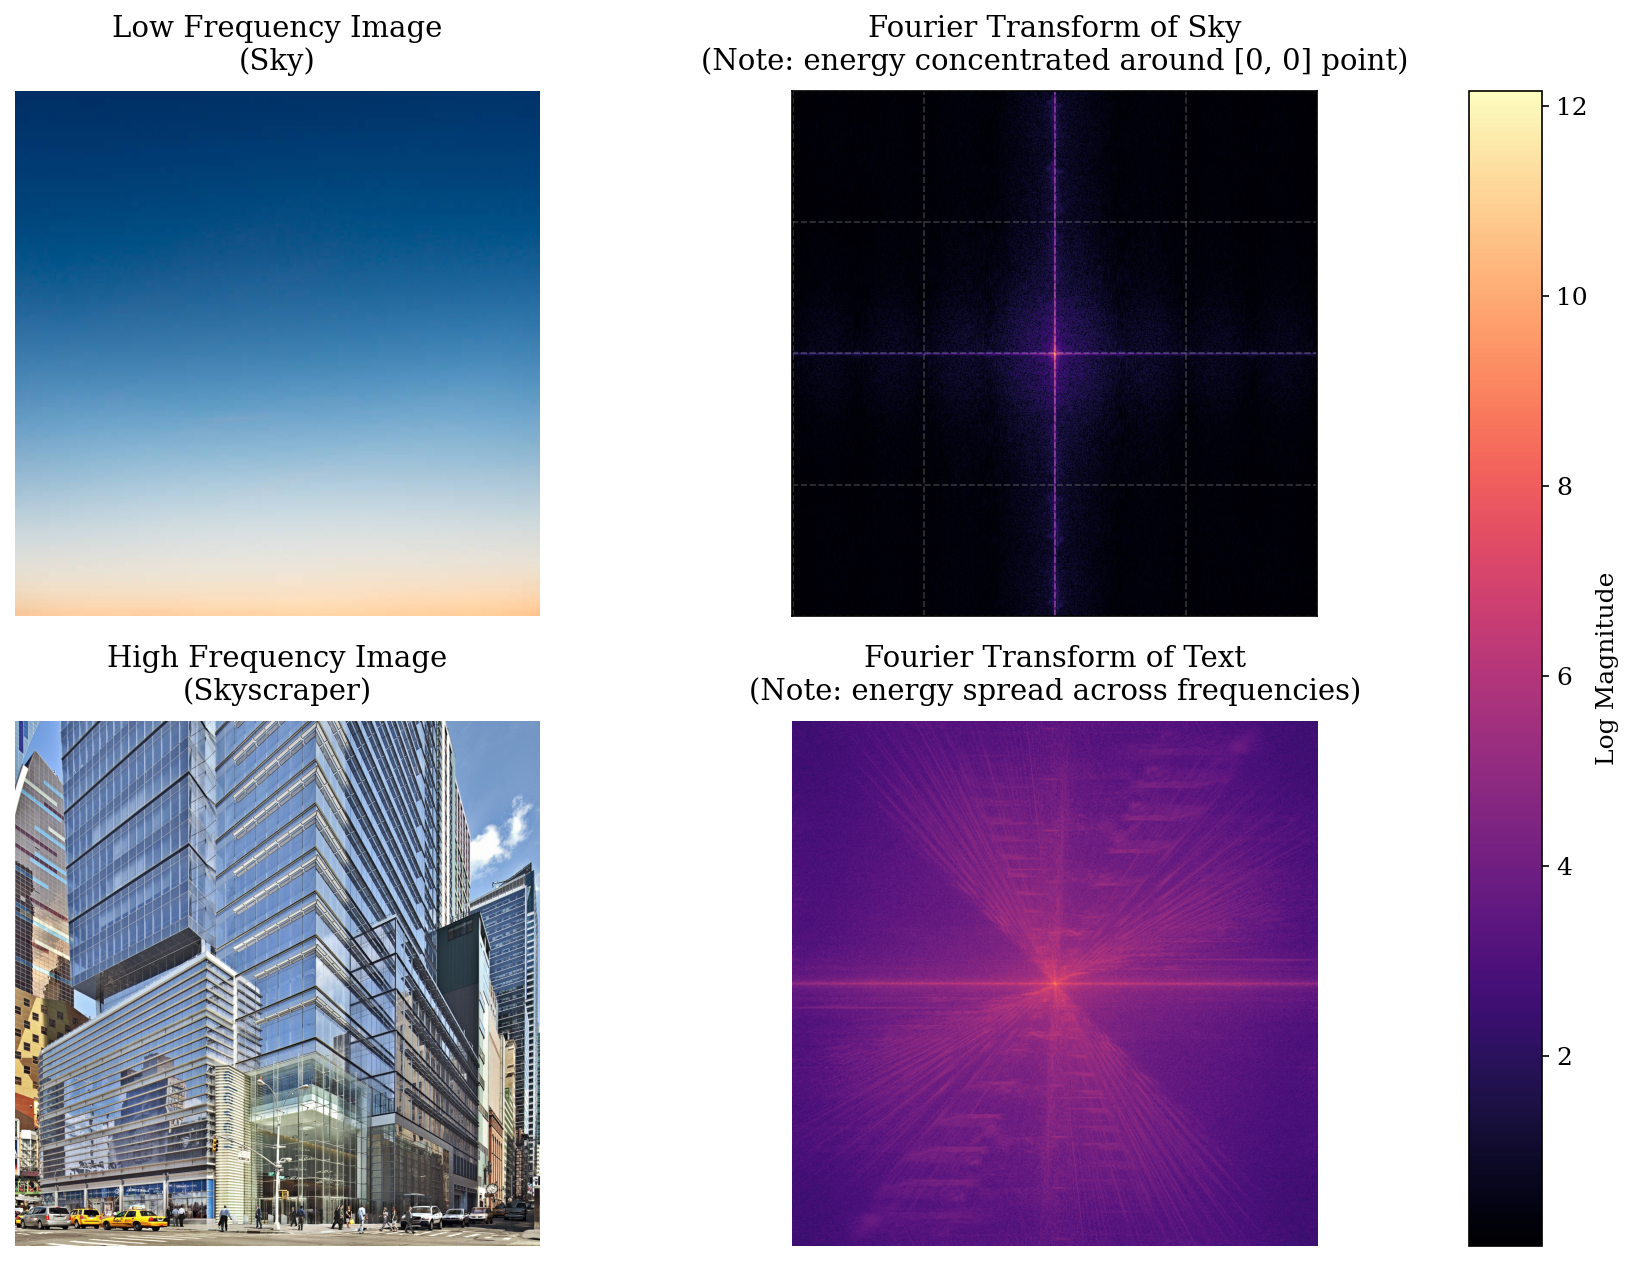

In [18]:
def create_text_image(size=(400, 400)):
    """Create an image with text (high frequency content)"""
    # Create a white background
    img = Image.new('RGB', size, 'white')
    draw = ImageDraw.Draw(img)
    
    # Add some text
    text = "HIGH\nFREQUENCY\nCONTENT"
    draw.text((size[0]//4, size[1]//4), text, fill='black', spacing=20,
              font=ImageFont.load_default(), size=40)
    
    # Convert to numpy array
    return np.array(img)

def compute_and_plot_fourier(image, ax, title):
    """Compute and plot Fourier transform of an image with coordinate axes"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image.copy()
    
    # Compute 2D FFT
    fft = fftpack.fft2(gray_image)
    fft_shifted = fftpack.fftshift(fft)
    magnitude_spectrum = np.log(1 + np.abs(fft_shifted))
    
    # Plot with original pixel coordinates
    im = ax.imshow(magnitude_spectrum, cmap='magma')
    
    # Get dimensions and set coordinate ticks
    rows, cols = gray_image.shape
    ax.set_xticks(np.linspace(0, cols-1, 5))  # 5 ticks across width
    ax.set_yticks(np.linspace(0, rows-1, 5))  # 5 ticks across height
    
    # Convert tick positions to centered coordinates
    x_positions = ax.get_xticks()
    y_positions = ax.get_yticks()
    x_labels = [int(x - cols//2) for x in x_positions]
    y_labels = [int(y - rows//2) for y in y_positions]
    
    # Set the tick labels
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    
    # Style the ticks
    ax.tick_params(axis='both', which='major', labelsize=8, colors='white')
    ax.grid(True, color='white', alpha=0.2, linestyle='--')
    
    
    return im

def create_frequency_comparison(sky_image_path, high_freq_image_path):
    # Read sky image (low frequency)
    sky_image = io.imread(sky_image_path)
    
    # Create text image (high frequency)
    text_image = io.imread(high_freq_image_path)
    
    # Create figure with adjusted width ratio
    fig = plt.figure(figsize=(14, 10), dpi=150)  # Increased figure width
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12
    
    # Create subplot grid with specific width ratios
    gs = plt.GridSpec(2, 3, width_ratios=[1, 1, 0.1])  # Added third column for colorbar
    
    
    
    #  Plot sky image and its FT
    ax1 = fig.add_subplot(gs[0, 0])
    plt.imshow(sky_image)
    plt.title('Low Frequency Image\n(Sky)', pad=10, fontsize=14)
    plt.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ft_plot1 = compute_and_plot_fourier(sky_image, ax2, 'Sky Fourier Transform')
    plt.title('Fourier Transform of Sky\n(Note: energy concentrated around [0, 0] point)', 
              pad=10, fontsize=14)
    # Note: Don't turn off axis here
    
    # Plot text image and its FT
    ax3 = fig.add_subplot(gs[1, 0])
    plt.imshow(text_image)
    plt.title('High Frequency Image\n(Skyscraper)', pad=10, fontsize=14)
    plt.axis('off')
    
    ax4 = fig.add_subplot(gs[1, 1])
    ft_plot2 = compute_and_plot_fourier(text_image, ax4, 'Text Fourier Transform')
    plt.title('Fourier Transform of Text\n(Note: energy spread across frequencies)', 
              pad=10, fontsize=14)
    plt.title('Fourier Transform of Text\n(Note: energy spread across frequencies)', 
              pad=10, fontsize=14)
    plt.axis('off')
    
    # Add colorbar in the third column
    cax = fig.add_subplot(gs[:, 2])  # Span both rows
    plt.colorbar(ft_plot1, cax=cax, label='Log Magnitude')
    
    # Adjust layout with smaller spacing
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    return fig

# Create and save the visualization
fig = create_frequency_comparison('../images/sky.jpg', '../images/skyscraper.jpg')
plt.savefig('../results/frequency_comparison.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()